# Aula 2

### Relatório automatizado com Python

* O que o código faz:
<BR>

- Pega os dados
- Trata os dados
- Faz as contas e gera as imagens
- Cria o PDF
- Envia por e-mail
<BR>
Informações que iremos pegar:

* Ibovespa
* S&P500
* Contratos de DI
* Dólar
* Inflação
* Selic

<br>

Passo a passo:

   - Pegar dados do Ibovespa/S&P500 no yahoo finance.
              - Calcular fechamento do dia, retorno no ano, retorno no mês, volatilidade 12m, retorno mês a mês e plotar gráfico do ativo. 
    - Pegar dados de DI no site da B3.
    - Pegar dados do dólar, inflação e selic no banco central. (3 linhas de código)
    - Criar PDF personalizado.
    - Enviar o e-mail.


O ideal é rodar o programa na parte da manhã, sempre.

In [ ]:
!pip install html5lib
!pip install webdriver-manager
!pip install python-bcb
!pip install pandas-datareader
!pip install mplfinance
!pip install selenium
!pip install FPDF
!pip install mplcyberpunk
!pip install python-dotenv
!pip install pywin32

In [ ]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime
from datetime import timedelta
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import mplcyberpunk
import time
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from webdriver_manager.firefox import GeckoDriverManager
import requests
from bcb import currency
from bcb import sgs
from fpdf import FPDF
from matplotlib.dates import date2num
import warnings
warnings.filterwarnings('ignore')

# Dados Ibovespa e S&P500

In [ ]:
#pegando dados do yahoo finance. 
indices = ['^BVSP', '^GSPC']

hoje = datetime.now()
um_ano_atras = hoje - timedelta(days = 366)

dados_mercado = pdr.get_data_yahoo(indices, start = um_ano_atras, end = hoje)

display(dados_mercado)

In [ ]:
#pegando fechamento de cada ativo

dados_fechamento = dados_mercado['Adj Close']
dados_fechamento.columns = ["Ibov", "S&P500"]
dados_fechamento = dados_fechamento.dropna()

dados_fechamento

In [ ]:
#pegando fechamento mensal e anual para calcular rentabilidades

dados_anuais = dados_fechamento.resample("Y").last()

display(dados_anuais)

dados_mensais = dados_fechamento.resample("M").last()

dados_mensais

In [ ]:
#calculando rentabilidades

retorno_diario = dados_fechamento.pct_change().dropna()

display(retorno_diario)

retorno_mes_a_mes = dados_mensais.pct_change().dropna()

retorno_mes_a_mes = retorno_mes_a_mes.iloc[1: , :]

display(retorno_mes_a_mes)

retorno_no_ano = dados_anuais.pct_change().dropna()

display(retorno_no_ano)

In [ ]:
#fechamento de dia

fechamento_de_dia = retorno_diario.iloc[-1, :]

display(fechamento_de_dia)

In [ ]:
#volatilidade ibov e S&P500

volatilidade_12m_ibov = retorno_diario['Ibov'].std() * np.sqrt(252)
volatilidade_12m_sp = retorno_diario['S&P500'].std() * np.sqrt(252)

print(volatilidade_12m_ibov)
print(volatilidade_12m_sp)

In [ ]:
fig, ax = plt.subplots()

plt.style.use("cyberpunk")

ax.plot(dados_fechamento.index, dados_fechamento['Ibov'])
ax.grid(False)
plt.savefig('ibov.png', dpi = 300)

plt.show()


In [ ]:
fig, ax = plt.subplots()

plt.style.use("cyberpunk")

ax.plot(dados_fechamento.index, dados_fechamento['S&P500'])
ax.grid(False)
plt.savefig('sp.png', dpi = 300)

plt.show()

# Dados DI

https://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?pagetype=pop&caminho=Resumo%20Estat%EDstico%20-%20Sistema%20Preg%E3o&Data=07/10/2019&Mercadoria=DI1

In [ ]:
dados_fechamento

In [ ]:
#pegando os dias úteis

data_inicial = dados_fechamento.index[0]

if datetime.now().hour < 10:

    data_final = dados_fechamento.index[-1]
    
else:
    
    data_final = dados_fechamento.index[-2]
    

print(data_inicial)

data_inicial = data_inicial.strftime("%d/%m/%Y")
data_final = data_final.strftime("%d/%m/%Y")

print(data_inicial)

In [ ]:
url_mais_att = f'''http://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?
pagetype=pop&caminho=Resumo%20Estat%EDstico%20-%20Sistema%20Preg%E3o&Data={data_final}
&Mercadoria=DI1'''

url_mais_antiga = f'''http://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?
pagetype=pop&caminho=Resumo%20Estat%EDstico%20-%20Sistema%20Preg%E3o&Data={data_inicial}
&Mercadoria=DI1'''

url_mais_antiga

In [44]:
def pegando_dados_di(url):
    
    driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()))
    
    sem_conexao = True
    
    while sem_conexao:
        try:
            driver.get(url)
            sem_conexao = False
        except:
            pass
            

    local_tabela = '''
    //div[@id = "containerPop"]//div[@id = "pageContent"]//form//table//tbody//tr[3]//td[3]//table
    '''

    local_indice = '''
    //div[@id = "containerPop"]//div[@id = "pageContent"]//form//table//tbody//tr[3]//td[1]//table
    '''

    elemento = driver.find_element("xpath", local_tabela)

    elemento_indice = driver.find_element("xpath", local_indice)

    html_tabela = elemento.get_attribute('outerHTML')
    html_indice = elemento_indice.get_attribute('outerHTML')

    driver.quit()

    tabela = pd.read_html(html_tabela)[0]
    indice = pd.read_html(html_indice)[0]

    return tabela, indice

In [45]:
di_mais_recente, indice_di_mais_recente = pegando_dados_di(url = url_mais_att)

di_mais_antigo, indice_di_mais_antigo = pegando_dados_di(url = url_mais_antiga)

[WDM] - Downloading: 18.8kB [00:00, 19.3MB/s]                   
[WDM] - Downloading: 18.8kB [00:00, 19.3MB/s]                   


In [46]:
display(di_mais_recente)
display(indice_di_mais_recente)

,0,1,2,3,4,5,6,7,8,9,10
0,AJUSTE ANTER. (3),AJUSTE CORRIG. (4),PREÇO ABERT.,PREÇO MÍN.,PREÇO MÁX.,PREÇO MÉD.,ÚLT. PREÇO,AJUSTE,VAR. PTOS.,ÚLT. OF. COMPRA,ÚLT. OF. VENDA
1,"99.291,34","99.291,34",13656,13652,13660,13656,13652,"99.291,57","0,23+",13652,13658
2,"98.286,05","98.286,05",13670,13666,13674,13670,13668,"98.285,89","0,16-",13668,13674
3,"97.191,99","97.191,99",13672,13672,13684,13680,13682,"97.190,94","1,05-",13680,13682
4,"96.108,98","96.108,98",13695,13685,13695,13685,13690,"96.107,78","1,20-",13685,13695
5,"95.237,64","95.237,64",13705,13675,13705,13679,13675,"95.234,50","3,14-",13675,13725
6,"94.126,81","94.126,81",13675,13675,13690,13683,13680,"94.122,99","3,82-",13680,13685
7,"93.273,49","93.273,49",13675,13675,13680,13675,13680,"93.273,54","0,05+",13650,0000
8,"92.264,66","92.264,66",13585,13585,13625,13616,13610,"92.269,66","5,00+",13610,0000
9,"91.343,63","91.343,63",13500,13455,13540,13530,13535,"91.334,58","9,05-",13530,13535


,0
0,VENCTO
1,X22
2,Z22
3,F23
4,G23
5,H23
6,J23
7,K23
8,M23
9,N23


In [43]:
# driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()))

# sem_conexao = True
    
# while sem_conexao:
#         try:
#             driver.get(url_mais_att)
#             sem_conexao = False
#         except:
#             pass
            

# local_tabela = '''//div[@id = "containerPop"]//div[@id = "pageContent"]
# //form//table//tbody//tr[3]//td[3]//table'''

# elemento = driver.find_element("xpath", local_tabela)

# html_tabela = elemento.get_attribute('outerHTML')

# html_tabela

# driver.quit()

# tabela = pd.read_html(html_tabela)[0]

# tabela

[WDM] - Downloading: 18.8kB [00:00, 19.9MB/s]                   


,0,1,2,3,4,5,6,7,8,9,10
0,AJUSTE ANTER. (3),AJUSTE CORRIG. (4),PREÇO ABERT.,PREÇO MÍN.,PREÇO MÁX.,PREÇO MÉD.,ÚLT. PREÇO,AJUSTE,VAR. PTOS.,ÚLT. OF. COMPRA,ÚLT. OF. VENDA
1,"99.291,34","99.291,34",13656,13652,13660,13656,13652,"99.291,57","0,23+",13652,13658
2,"98.286,05","98.286,05",13670,13666,13674,13670,13668,"98.285,89","0,16-",13668,13674
3,"97.191,99","97.191,99",13672,13672,13684,13680,13682,"97.190,94","1,05-",13680,13682
4,"96.108,98","96.108,98",13695,13685,13695,13685,13690,"96.107,78","1,20-",13685,13695
5,"95.237,64","95.237,64",13705,13675,13705,13679,13675,"95.234,50","3,14-",13675,13725
6,"94.126,81","94.126,81",13675,13675,13690,13683,13680,"94.122,99","3,82-",13680,13685
7,"93.273,49","93.273,49",13675,13675,13680,13675,13680,"93.273,54","0,05+",13650,0000
8,"92.264,66","92.264,66",13585,13585,13625,13616,13610,"92.269,66","5,00+",13610,0000
9,"91.343,63","91.343,63",13500,13455,13540,13530,13535,"91.334,58","9,05-",13530,13535


In [47]:
def tratando_dados_di(df_dados, indice):
    
    
    df_dados.columns = df_dados.loc[0]

    df_dados = df_dados['ÚLT. PREÇO']

    df_dados = df_dados.drop(0, axis = 0)

    indice.columns = indice.loc[0]

    indice_di = indice['VENCTO']

    indice = indice.drop(0, axis = 0)
    
    df_dados.index = indice['VENCTO']
    
    print(df_dados)
    
    df_dados = df_dados.astype(int)

    df_dados = df_dados[df_dados != 0]

    df_dados = df_dados/1000
    
    print(df_dados)

    return df_dados

In [48]:
dados_di_recente_tratado = tratando_dados_di(di_mais_recente, indice_di_mais_recente)

dados_di_antigo_tratado = tratando_dados_di(di_mais_antigo, indice_di_mais_antigo)

VENCTO
X22    13652
Z22    13668
F23    13682
G23    13690
H23    13675
J23    13680
K23    13680
M23    13610
N23    13535
Q23    13430
U23    13315
V23    13190
F24    12815
J24    12470
N24    12130
V24    11890
F25    11660
J25    11565
N25    11540
V25    11520
F26    11530
J26    11520
N26    11545
V26    11525
F27    11540
J27    11545
N27    11560
V27    11550
F28    11580
F29    11690
F30    11720
F31    11770
F32    11770
F33    11790
F34    11800
F35     0000
F36    11790
F37     0000
Name: ÚLT. PREÇO, dtype: object
VENCTO
X22    13.652
Z22    13.668
F23    13.682
G23    13.690
H23    13.675
J23    13.680
K23    13.680
M23    13.610
N23    13.535
Q23    13.430
U23    13.315
V23    13.190
F24    12.815
J24    12.470
N24    12.130
V24    11.890
F25    11.660
J25    11.565
N25    11.540
V25    11.520
F26    11.530
J26    11.520
N26    11.545
V26    11.525
F27    11.540
J27    11.545
N27    11.560
V27    11.550
F28    11.580
F29    11.690
F30    11.720
F31    11.770
F32    11.77

In [49]:
dados_di_antigo_tratado

VENCTO
X21     6.304
Z21     6.860
F22     7.304
G22     7.580
H22     7.830
J22     8.050
K22     8.235
M22     8.425
N22     8.580
Q22     8.685
U22     8.780
V22     8.875
X22     8.935
Z22     8.980
F23     9.060
J23     9.245
N23     9.460
V23     9.595
F24     9.700
N24     9.895
V24     9.960
F25    10.010
J25    10.060
N25    10.120
V25    10.190
F26    10.250
J26    10.260
F27    10.440
F28    10.580
F29    10.700
F31    10.850
F33    11.000
Name: ÚLT. PREÇO, dtype: float64

In [51]:
legenda = pd.Series(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                    index = ['F', 'G', 'H', 'J', 'K', 'M', 'N', 'Q', 'U', 'V', 'X', 'Z'])

legenda
legenda["F"]

'Jan'

In [52]:
def transformando_codigo_em_data(df):

    lista_datas = []

    for indice in df.index:

        letra = indice[0]
        ano = indice[1:3]

        mes = legenda[letra]

        data = f"{mes}-{ano}"

        data = datetime.strptime(data, "%b-%y")

        lista_datas.append(data)
        

    df.index = lista_datas  
    
    return df

In [53]:
dados_di_recente_tratado = transformando_codigo_em_data(dados_di_recente_tratado)
dados_di_antigo_tratado = transformando_codigo_em_data(dados_di_antigo_tratado)

dados_di_recente_tratado

2022-11-01    13.652
2022-12-01    13.668
2023-01-01    13.682
2023-02-01    13.690
2023-03-01    13.675
2023-04-01    13.680
2023-05-01    13.680
2023-06-01    13.610
2023-07-01    13.535
2023-08-01    13.430
2023-09-01    13.315
2023-10-01    13.190
2024-01-01    12.815
2024-04-01    12.470
2024-07-01    12.130
2024-10-01    11.890
2025-01-01    11.660
2025-04-01    11.565
2025-07-01    11.540
2025-10-01    11.520
2026-01-01    11.530
2026-04-01    11.520
2026-07-01    11.545
2026-10-01    11.525
2027-01-01    11.540
2027-04-01    11.545
2027-07-01    11.560
2027-10-01    11.550
2028-01-01    11.580
2029-01-01    11.690
2030-01-01    11.720
2031-01-01    11.770
2032-01-01    11.770
2033-01-01    11.790
2034-01-01    11.800
2036-01-01    11.790
Name: ÚLT. PREÇO, dtype: float64

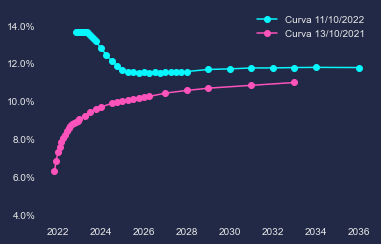

In [55]:
fig, ax = plt.subplots()


plt.style.use("cyberpunk")

ax.set_ylim(3.5, 15)
ax.plot(dados_di_recente_tratado.index, dados_di_recente_tratado.values, 
                                    label = f"Curva {data_final}", marker='o')
ax.plot(dados_di_antigo_tratado.index, dados_di_antigo_tratado.values, 
        label = f"Curva {data_inicial}", marker='o')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
ax.grid(False)
plt.savefig('juros.png', dpi = 300)

plt.show()

# Dados do Banco Central (Selic, Inflação e Dólar)

https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
<br>
https://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados?formato=json

In [56]:
#série selic

selic = sgs.get({'selic':432}, start = '2010-01-01')

selic

,selic
Date,
2010-01-01,8.75
2010-01-02,8.75
2010-01-03,8.75
2010-01-04,8.75
2010-01-05,8.75
...,...
2022-10-09,13.75
2022-10-10,13.75
2022-10-11,13.75


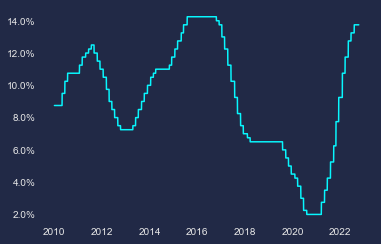

In [57]:
fig, ax = plt.subplots()

plt.style.use("cyberpunk")

ax.plot(selic.index, selic['selic'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(False)
plt.savefig('selic.png', dpi = 300)

plt.show()

In [58]:
# Série do IPCA e IGP-M
inflacao = sgs.get({'ipca': 433,
             'igp-m': 189}, start = um_ano_atras + timedelta(180))

inflacao

,ipca,igp-m
Date,,
2022-04-01,1.06,1.41
2022-05-01,0.47,0.52
2022-06-01,0.67,0.59
2022-07-01,-0.68,0.21
2022-08-01,-0.36,-0.70
2022-09-01,-0.29,-0.95


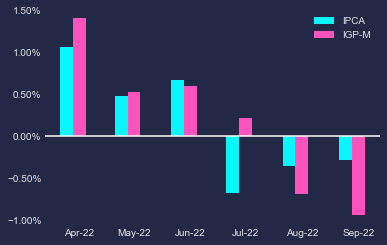

In [64]:
datas_numericas = date2num(inflacao.index)

fig, ax = plt.subplots()

ax.bar(datas_numericas-7, inflacao['ipca'], label = "IPCA", width=7)
ax.bar(datas_numericas, inflacao['igp-m'], label = "IGP-M", width=7)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis_date()
formato_data = mdates.DateFormatter('%b-%y')
ax.xaxis.set_major_formatter(formato_data)
ax.grid(False)
plt.axhline(y=0, color = 'w')
plt.legend()
plt.savefig('inflacao.png', dpi = 300)

plt.show()

In [65]:
# Importas moedas 

dolar = currency.get('USD', start=um_ano_atras, end=datetime.now())
dolar

,USD
Date,
2021-10-13,5.5471
2021-10-14,5.4988
2021-10-15,5.4510
2021-10-18,5.5193
2021-10-19,5.5521
...,...
2022-10-06,5.2009
2022-10-07,5.2221
2022-10-10,5.1941


In [66]:
dolar_mensal = dolar.resample("M").last()
dolar_anual = dolar.resample("Y").last()

In [67]:
#calculando rentabilidades

dolar_diario = dolar.pct_change().dropna()
fechamento_de_dia_dolar = dolar_diario.iloc[-1, :]

display(fechamento_de_dia_dolar)

retorno_mes_a_mes_dolar = dolar_mensal.pct_change().dropna()
retorno_mes_a_mes_dolar = retorno_mes_a_mes_dolar.iloc[1: , :]

display(retorno_mes_a_mes_dolar)

retorno_no_ano_dolar = dolar_anual.pct_change().dropna()

display(retorno_no_ano_dolar)

USD    0.018226
Name: 2022-10-13 00:00:00, dtype: float64

,USD
Date,
2021-12-31,-0.007011
2022-01-31,-0.039978
2022-02-28,-0.040691
2022-03-31,-0.078141
2022-04-30,0.038267
2022-05-31,-0.038666
2022-06-30,0.107657
2022-07-31,-0.009469
2022-08-31,-0.001812


,USD
Date,
2022-12-31,-0.04996


In [68]:
#Volatilidade dolar

volatilidade_12m_dolar = dolar_diario['USD'].std() * np.sqrt(252)

volatilidade_12m_dolar

0.14953556873350543

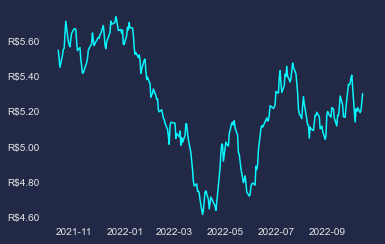

In [69]:
fig, ax = plt.subplots()

plt.style.use("cyberpunk")

ax.plot(dolar.index, dolar['USD'])
ax.yaxis.set_major_formatter('R${x:1.2f}')
ax.grid(False)
plt.savefig('dolar.png', dpi = 300)

plt.show()

# Criar PDF

In [84]:
fechamento_de_dia
# volatilidade_12m_ibov
# volatilidade_12m_sp
# retorno_mes_a_mes
# retorno_no_ano
# fechamento_de_dia_dolar
# retorno_mes_a_mes_dolar
# retorno_no_ano_dolar

Ibov     -0.001686
S&P500    0.022589
Name: 2022-10-13 00:00:00, dtype: float64

In [72]:
meses = []

for indice in retorno_mes_a_mes.index:

    mes = indice.strftime("%b")
    
    meses.append(mes)
    
meses

['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']

In [86]:
class PDF(FPDF):
    
    def header(self):
        
        self.image('logo.png', 10, 8, 40)
        self.set_font('Arial', 'B', 20)
        self.ln(15)
        self.set_draw_color(35, 155, 132) #cor RGB
        self.cell(15, ln = False)
        self.cell(150, 15, f"Relatório de mercado {data_final}", 
                  border = True, ln = True, align = "C")
        self.ln(5)
        
    def footer(self):
        
        self.set_y(-15) #espaço ate o final da folha
        self.set_font('Arial', 'I', 10)
        self.cell(0, 10, f"{self.page_no()}/{{nb}}", align = "C")

In [87]:
#Definindo config básicas do PDF

pdf = PDF("P", "mm", "Letter")
pdf.set_auto_page_break(auto = True, margin = 15)
pdf.alias_nb_pages()
pdf.add_page()
pdf.set_fill_color(255, 255, 255)
pdf.set_draw_color(35, 155, 132)

#pdf.output('aula2.pdf')

In [88]:
pdf.image('nave1.png', x = 115, y = 70, w = 75, h = 33)
pdf.set_font('Arial', 'B', 18)
pdf.cell(0, 10, "1 - Ações e câmbio", ln = True,  border = False, fill = False)
pdf.ln(2)

pdf.set_font('Arial', '', 14)
pdf.cell(0, 15, "1.1 Fechamento do mercado", ln = True,  border = False, fill = True)

pdf.ln(7)

#pdf.output('aula2.pdf')

In [89]:
#fechamento ibov
pdf.set_font('Arial', '', 13)
pdf.cell(25, 15, " Ibovespa", ln = False,  border = True, fill = True)
pdf.cell(20, 15, f" {str(round(fechamento_de_dia[0] * 100, 2))}%", ln = True, 
         border = True, fill = False)

#fechamento s&p500
pdf.cell(25, 15, " S&P500", ln = False,  border = True, fill = True)
pdf.cell(20, 15, f" {str(round(fechamento_de_dia[1] * 100, 2))}%", ln = True,  border = True, fill = False)

#fechamento Dólar
pdf.cell(25, 15, " Dólar", ln = False,  border = True, fill = True)
pdf.cell(20, 15, f" {str(round(fechamento_de_dia_dolar[0] * 100, 2))}%", ln = True,  border = True, fill = False)

pdf.ln(7)

#pdf.output('aula2.pdf')

In [90]:
#imagens
pdf.set_font('Arial', '', 14)
pdf.cell(0, 15, "   1.2 Gráficos Ibovespa, S&P500 e Dólar", ln = True,  border = False, fill = False)

pdf.cell(95, 15, "Ibovespa", ln = False,  border = False, fill = False, align = "C")
pdf.cell(100, 15, "S&P500", ln = True,  border = False, fill = False, align = "C")
pdf.image("ibov.png", w = 80, h = 70, x = 20, y = 160)
pdf.image("sp.png", w = 80, h = 70, x = 115, y = 160)

pdf.ln(130)

pdf.cell(0, 15, "Dólar", ln = True,  border = False, fill = False, align = "C")
pdf.image("dolar.png", w = 100, h = 75, x = 58)


pdf.ln(2)

#pdf.output('aula2.pdf')

In [91]:
pdf.set_font('Arial', '', 14)
pdf.cell(0, 15, "   1.3 Rentabilidade mês a mês", ln = True,  border = False, fill = False)


#escrevendo os meses
pdf.cell(17, 10, "", ln = False,  border = False, fill = True, align = "C")

for mes in meses:
    
    pdf.cell(16, 10, mes, ln = False,  border = True, fill = True, align = "C")


pdf.ln(10)

#pdf.output('aula2.pdf')

In [92]:
#escrevendo o ibov

pdf.cell(17, 10, "Ibov", ln = False,  border = True, fill = True, align = "C")

pdf.set_font('Arial', '', 12)
for rent in retorno_mes_a_mes['Ibov']:
    
    pdf.cell(16, 10, f" {str(round(rent * 100, 2))}%", ln = False,  border = True, align = "C")

pdf.ln(10)

#escrevendo o S&P

pdf.cell(17, 10, "S&P500", ln = False,  border = True, fill = True, align = "C")

pdf.set_font('Arial', '', 12)
for rent in retorno_mes_a_mes['S&P500']:
    
    pdf.cell(16, 10, f" {str(round(rent * 100, 2))}%", ln = False,  border = True, align = "C")

pdf.ln(10)

#escrevendo o Dólar

pdf.cell(17, 10, "Dólar", ln = False,  border = True, fill = True, align = "C")

pdf.set_font('Arial', '', 12)
for rent in retorno_mes_a_mes_dolar['USD']:
    
    pdf.cell(16, 10, f" {str(round(rent * 100, 2))}%", ln = False,  border = True, align = "C")

pdf.ln(10)

#pdf.output('aula2.pdf')

In [93]:
#rent anual
pdf.set_font('Arial', '', 14)
pdf.cell(0, 15, "   1.4 Rentabilidade no ano", ln = True,  border = False, fill = False)

#rent anual ibov
pdf.set_font('Arial', '', 13)
pdf.cell(25, 10, "Ibovespa", ln = False,  border = True, fill = True, align = "C")
pdf.cell(20, 10, f" {str(round(retorno_no_ano.iloc[0, 0] * 100, 2))}%", ln = True,  border = True, align = "C")

#rent anual S&P
pdf.cell(25, 10, "S&P500", ln = False,  border = True, fill = True, align = "C")
pdf.cell(20, 10, f" {str(round(retorno_no_ano.iloc[0, 1] * 100, 2))}%", ln = True,  border = True, align = "C")

#rent anual Dólar
pdf.cell(25, 10, "Dólar", ln = False,  border = True, fill = True, align = "C")
pdf.cell(20, 10, f" {str(round(retorno_no_ano_dolar.iloc[0, 0] * 100, 2))}%", ln = True,  border = True, align = "C")


pdf.ln(20)


#pdf.output('aula2.pdf')

In [94]:
#volatilidade
pdf.set_font('Arial', '', 14)
pdf.cell(0, 15, "   1.5 Volatilidade 12M", ln = True,  border = False, fill = False)

#vol ibov
pdf.set_font('Arial', '', 13)
pdf.cell(25, 10, "Ibovespa", ln = False,  border = True, fill = True, align = "C")
pdf.cell(20, 10, f" {str(round(volatilidade_12m_ibov * 100, 2))}%", ln = True,  border = True, align = "C")

#vol s&p500
pdf.cell(25, 10, "S&P500", ln = False,  border = True, fill = True, align = "C")
pdf.cell(20, 10, f" {str(round(volatilidade_12m_sp * 100, 2))}%", ln = True,  border = True, align = "C")

#vol dolar
pdf.cell(25, 10, "Dólar", ln = False,  border = True, fill = True, align = "C")
pdf.cell(20, 10, f" {str(round(volatilidade_12m_dolar * 100, 2))}%", ln = True,  border = True, align = "C")

pdf.image('nave2.png', x = 115, y = 45, w = 70, h = 70, type = '', link = '')

pdf.ln(7)

#pdf.output('aula2.pdf')

In [95]:
pdf.set_font('Arial', 'B', 18)
pdf.cell(0, 15, "2 - Dados econômicos", ln = True,  border = False, fill = False)

pdf.set_font('Arial', '', 14)
pdf.cell(0, 15, "2.1 Curva de juros", ln = True,  border = False, fill = False)
pdf.image("juros.png", w = 125, h = 100, x = 40, y = 140)

pdf.ln(135)

pdf.cell(0, 15, "2.2 Inflacão", ln = True,  border = False, fill = False)
pdf.image("inflacao.png", w = 110, h = 90, x = 40)


pdf.cell(0, 15, "2.3 Selic", ln = True,  border = False, fill = False)
pdf.image("selic.png", w = 110, h = 90, x = 40)

pdf.output('aula2.pdf')

''

* Pode colocar maiores altas do mercado
* Pode pegar dados da economia americana direto do FRED com 1 linha de código e inserir
* Pode pegar dados da CVM de balanço e colocar quais empresas reportaram resultado na semana
* Pode colocar sua carteira pessoal e comparar com os benchmarks (projeto mais complexo envolvendo banco de dados, leitura de notas, etc)

In [ ]:
!pip install pywin32

In [96]:
import win32com.client as win32

In [97]:
#integração com seu outlook
outlook = win32.Dispatch('outlook.application')

In [98]:
#criar email
email = outlook.CreateItem(0)

In [99]:
email.To = "botcamp@edufinance.com.br"
email.Subject = "Relatório diário"
email.Body = '''Segue em anexo o relatório diário.

Abs, Brenno

'''

anexo = r"C:/Users/lsiqu/lancamento_2-main/aula2.pdf"

email.Attachments.Add(anexo)

email.Send()


# Aula 3

* Modelo de investimento do zero
* Abertura das inscrições codigo.py
* Material da aula no grupo do WPP.